In [29]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


drakes_test {'ddg': 1.0762512499999999, 'ddg_std': 0.8210351286830646, 'pos_ddg_prop': 0.8587239583333334, 'scrmsd': 0.8988032639026642, 'scrmsd_std': 1.202034489322876, 'low_scrmsd_prop': 0.9342447916666666, 'success_rate': 0.7975260416666666, 'll': -144.11238861083984, 'll_std': 41.5608073079779}
pretrained_test_ddg_linear_N=100_lambda=0.0005_stepsperlevel=1 {'ddg': 0.6420216, 'ddg_std': 1.1900381763457704, 'pos_ddg_prop': 0.677734375, 'll': -129.10635375976562, 'll_std': 42.41590778419062}
pretrained_test_ddg_beam_N=100_W=1_stepsperlevel=1 {'ddg': 1.2478552, 'ddg_std': 1.1682462051019913, 'pos_ddg_prop': 0.8294270833333334, 'll': -133.29671478271484, 'll_std': 41.59139589199887}
pretrained_test_ddg_spectral_N=100_stepsperlevel=1 {'ddg': 0.721250475, 'ddg_std': 1.183092981961504, 'pos_ddg_prop': 0.6946614583333334, 'll': -129.09268951416016, 'll_std': 41.99176707409812}
pretrained_test_ddg_bon_N=100 {'ddg': 0.7896066749999999, 'ddg_std': 1.1914476812401638, 'pos_ddg_prop': 0.69596354

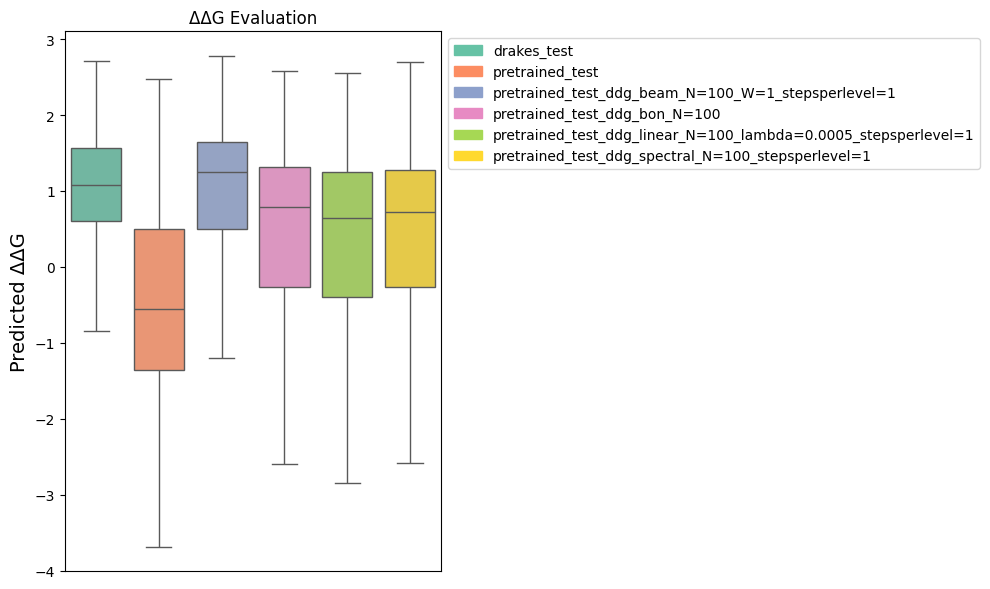

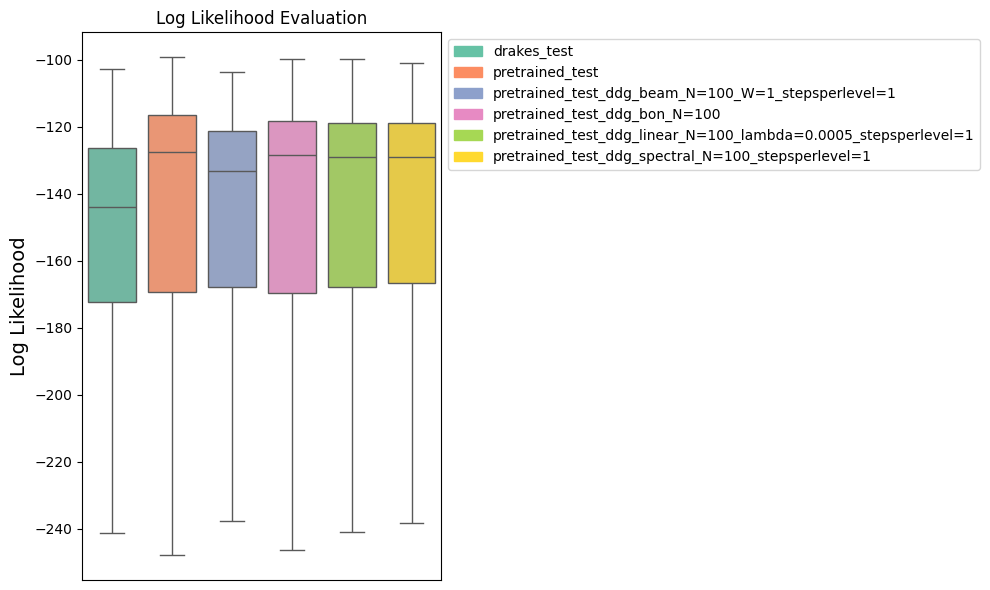

In [31]:
display_experiments(100, 'ddg', dataset='test')